In [0]:
! unzip /content/8f504160af7a11e9.zip

Archive:  /content/8f504160af7a11e9.zip
   creating: DataSets/
  inflating: DataSets/Train.csv      
  inflating: DataSets/sample_submission.csv  
  inflating: DataSets/Test.csv       


In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor ,plot_importance,cv
from sklearn.metrics import mean_squared_error,accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
#import xgboost as xgb
from warnings import filterwarnings
from sklearn.neighbors import KNeighborsRegressor

filterwarnings('ignore')

In [0]:
df= pd.read_csv('DataSets/Train.csv')
test=pd.read_csv('DataSets/Test.csv')
print('shape of train',df.shape)


shape of train (33750, 15)


In [0]:
df=df.drop_duplicates(['date_time'])
print(df.shape)
all_data=df.append(test,sort=False)

(28589, 15)


In [0]:
print(all_data['traffic_volume'].isna().sum())
all_data['traffic_volume'].fillna(0,inplace=True)
print(all_data['traffic_volume'].isna().sum())



14454
0


In [0]:
test['visibility_in_miles'].describe()

count    14454.000000
mean         5.005535
std          2.586276
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: visibility_in_miles, dtype: float64

In [0]:
df.isna().sum()

date_time              0
is_holiday             0
air_pollution_index    0
humidity               0
wind_speed             0
wind_direction         0
visibility_in_miles    0
dew_point              0
temperature            0
rain_p_h               0
snow_p_h               0
clouds_all             0
weather_type           0
weather_description    0
traffic_volume         0
dtype: int64

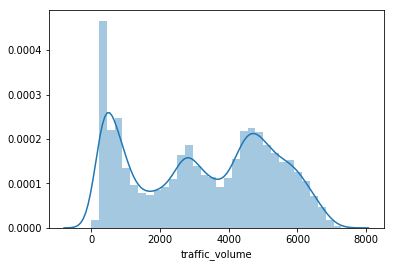

In [0]:
sns.distplot(df['traffic_volume'])

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 15 columns):
date_time              33750 non-null object
is_holiday             33750 non-null object
air_pollution_index    33750 non-null int64
humidity               33750 non-null int64
wind_speed             33750 non-null int64
wind_direction         33750 non-null int64
visibility_in_miles    33750 non-null int64
dew_point              33750 non-null int64
temperature            33750 non-null float64
rain_p_h               33750 non-null float64
snow_p_h               33750 non-null float64
clouds_all             33750 non-null int64
weather_type           33750 non-null object
weather_description    33750 non-null object
traffic_volume         33750 non-null int64
dtypes: float64(3), int64(8), object(4)
memory usage: 3.9+ MB


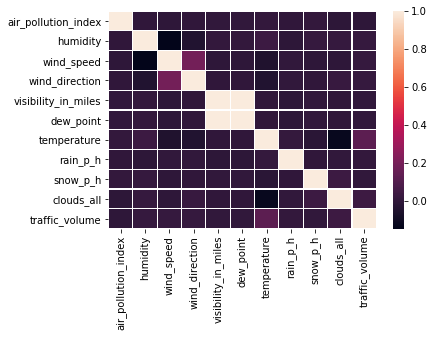

In [0]:

sns.heatmap(df.corr(),linewidths=.2)

In [0]:
def feature_engineering(df,label):
  
  
    ## date_time
    df['date_time']=pd.to_datetime(df['date_time'])


    df['year']=df['date_time'].dt.year
    df['month']=df['date_time'].dt.month
    df['day_of_month']=df['date_time'].dt.day
    df['week_day']=df['date_time'].dt.weekday
    df['hour']=df['date_time'].dt.hour
    df.drop(['date_time','air_pollution_index','humidity','wind_speed','dew_point',
            'weather_description','clouds_all'],inplace=True,axis=1)
    
    df['morning'] = df['hour'].apply(lambda x : 1 if 6 <= x < 12 else 0 )
    df['eveng'] =   df['hour'].apply(lambda x : 1 if 12 <= x < 18 else 0 )
    df['night'] = df['hour'].apply(lambda x : 1 if 18 <= x < 24 else 0 )
    df['e_morning'] = df['night'] = df['hour'].apply(lambda x : 1 if 24 <= x < 6 else 0 )

    #df['visibile'] = df['visibility_in_miles'] / df['hour']
    df['ph'] = df['rain_p_h'] + df['snow_p_h']
    
    #df['total'] = df['air_pollution_index'] + df['humidity'] + df['wind_speed'] + df['dew_point']
    
    

    lb = LabelEncoder()
    #df['weather_description'] = lb.fit_transform(df['weather_description'])
    df['is_holiday'] = lb.fit_transform(df['is_holiday'])
    
    y=df['traffic_volume']
    df.drop(['traffic_volume'],inplace=True,axis=1)
    
    df=pd.get_dummies(df)
    features=(df.columns)
    
    #scaler=MinMaxScaler()
    #df=scaler.fit_transform(df)
    
    
    return df,y,features
    
  
  

  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  

In [0]:

all_data,y,features=feature_engineering(all_data,'train')
train=all_data[:df.shape[0]]
y=y[:df.shape[0]]
test=all_data[df.shape[0]:]


In [0]:
len(test)

14454

In [0]:
def rmse(y_test,y_pre):
  score=np.sqrt(mean_squared_error(y_test,y_pre))
  return  score 

In [0]:
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size=.15,random_state=42)


In [0]:
xgb=XGBRegressor(max_depth=20,n_estimators=400,leaning_rate=.2,gamma=.2,colsample_bylevel=.8)


In [0]:
xgb.fit(train,y)
y_pre=xgb.predict(train)


[06:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
train.drop(['visibile'],inplace=True,axis=1)

In [0]:
print(rmse(y,y_pre))

0.18311611907205408


In [0]:
from sklearn.model_selection import KFold 


kf = KFold(n_splits=3, random_state=None) 
vals=[]
for train_index, test_index in kf.split(train):
  
      #print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = train.iloc[train_index], train.iloc[test_index] 
      y_train, y_test = y[train_index], y[test_index]
      xgb.fit(X_train,y_train)
      x=(rmse(xgb.predict(X_test),y_test))
      vals.append(x)

np.mean(vals)
      
      

[02:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:49:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


534.9419841767101

In [0]:
print('train rmse',rmse(xgb.predict(X_train),y_train))
y_pre=xgb.predict(X_test)
y_pre=[max(0,x) for x in y_pre]
print(rmse(y_test,y_pre))
#print('test rmse',rmse(y_scaler.inverse_transform(np.array(y_test).reshape(-1,1)),y_scaler.inverse_transform(np.array(y_pre).reshape(-1,1))))


train rmse 272.6310581177716
360.2113566822


In [0]:

print('train rmse',rmse(rf.predict(train),y))
#y_pre=rf.predict(X_test)
#y_pre=[max(0,x) for x in y_pre]
#print('test rmse',rmse(y_test,y_pre))

train rmse 196.66896011401624


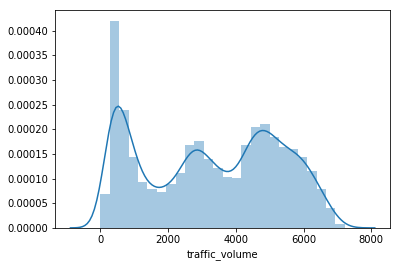

In [0]:
sns.distplot(y_train)

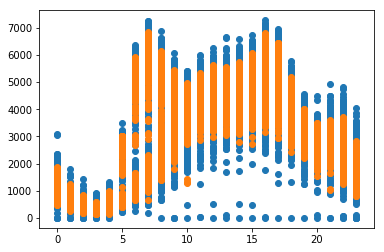

In [0]:
plt.scatter(train['hour'],y)
plt.scatter(test['hour'],pred)


In [0]:

#test = feature_engineering(test,'test')

pred=xgb.predict(test)
pred=[max(0,x) for x in pred]


In [0]:
pred= [round(x) for x in pred]

In [0]:
submissions=pd.read_csv('DataSets/sample_submission.csv')
test_time=pd.read_csv('DataSets/Test.csv')['date_time']
sub = pd.DataFrame({'date_time':test_time,'traffic_volume':pred})




In [0]:
sub.head()

,date_time,traffic_volume
0,2017-05-18 00:00:00,719.837830
1,2017-05-18 00:00:00,885.540222
2,2017-05-18 00:00:00,578.294556
3,2017-05-18 01:00:00,392.693115
4,2017-05-18 01:00:00,411.660065


In [0]:

sub.to_csv('prediction_over1.csv',index=False)

In [0]:
sub.describe()

,traffic_volume
count,14454.000000
mean,3227.126954
std,1870.498332
min,95.000000
25%,1326.000000
50%,3463.500000
75%,4758.750000
max,6907.000000


In [0]:
feat_imp = pd.Series(xgb.booster().get_fscore).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

TypeError: ignored

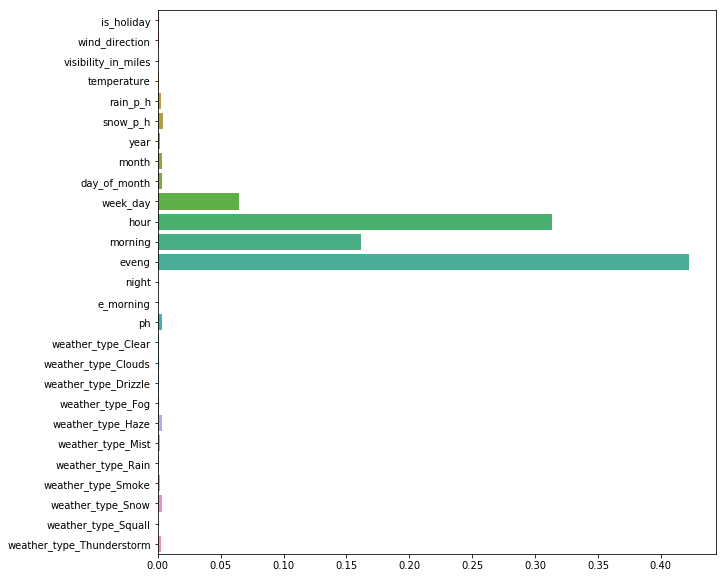

In [0]:
x=xgb.feature_importances_
plt.figure(figsize=(10,10))
sns.barplot(x=x,y=features)
#plt.xlabel(features,rotation = '90')


In [0]:
len(features[:-1]),len(x)

(40, 40)